## Sentiment Analysis

##### Improvement

1. Experiment with RNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from utils import preprocess_text, pad_sequence, train_test_split_tensors, train_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Neeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Neeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Neeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data preparation

#### Load the dataset

In [2]:
train = pd.read_csv("../data/IMDB Sentiment Analysis/Train.csv")
test = pd.read_csv("../data/IMDB Sentiment Analysis/Test.csv")
val = pd.read_csv("../data/IMDB Sentiment Analysis/Valid.csv")

In [3]:
df_all = pd.concat([train, val, test], axis=0)

In [4]:
df_all.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
dataset_size = len(df_all)
dataset_size

50000

#### Preprocess Dataset

In [6]:
df_all["word_list"] = df_all["text"].apply(lambda text: preprocess_text(text))

In [7]:
df_all.head()

,text,label,word_list
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, b, watching, loving, thunderbird, mate,..."
1,"When I put this movie in my DVD player, and sa...",0,"[put, movie, dvd, player, sat, coke, chip, exp..."
2,Why do people who do not know what a particula...,0,"[people, know, particular, time, past, like, f..."
3,Even though I have great interest in Biblical ...,0,"[even, though, great, interest, biblical, movi..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dad, army, fan, nothing, ever,..."


In [8]:
df_all["sentence_length"] = df_all["word_list"].apply(lambda word_list: len(word_list))

<Figure size 1152x576 with 0 Axes>

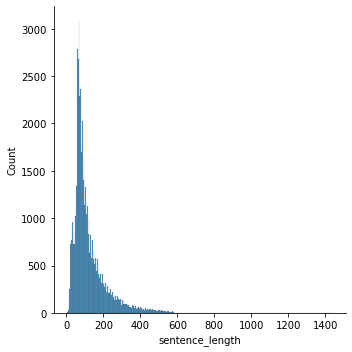

In [9]:
plt.figure(figsize=(16, 8))
sns.displot(df_all["sentence_length"])

In [10]:
print(f"mean: {df_all['sentence_length'].mean()} \
        median: {df_all['sentence_length'].median()} \
        std: {df_all['sentence_length'].std()} \
        max: {df_all['sentence_length'].max()} \
        min: {df_all['sentence_length'].min()}")

mean: 121.2643         median: 90.0         std: 91.36838495423598         max: 1438         min: 3


In [11]:
max_sequence_length = int(df_all['sentence_length'].mean() + 2 * df_all['sentence_length'].std())
max_sequence_length

304

#### Build Vocab

In [12]:
all_words_list = []
df_all["word_list"].apply(lambda word_list: all_words_list.extend(word_list))

0       None
1       None
2       None
3       None
4       None
        ... 
4995    None
4996    None
4997    None
4998    None
4999    None
Name: word_list, Length: 50000, dtype: object

##### Get frequency of the words

In [13]:
from collections import Counter

In [14]:
word_frequency = Counter(all_words_list)

In [15]:
print(f"mean: {np.mean(list(word_frequency.values()))} \
        median: {np.median(list(word_frequency.values()))} \
        std: {np.std(list(word_frequency.values()))} \
        max: {max(word_frequency.values())} \
        min: {min(word_frequency.values())}")

mean: 40.14523412257005         median: 1.0         std: 639.2531565816863         max: 114803         min: 1


We can see that there is a huge standard deviation

For Convinience we'll take the min_frequency of the word to appear in the vocabulary as 20

In [16]:
min_frequency = 20

In [17]:
new_word_frequency = {word: freq for word, freq in word_frequency.items() if freq > min_frequency}

In [18]:
vocab_size = len(new_word_frequency)

##### Create Word2Idx

In [19]:
word2idx = {word: idx + 2 for idx, word in enumerate(new_word_frequency)}

#### Preparing data for training

##### Converting words to indices

In [20]:
unk_idx = 1

In [21]:
df_all["word_indices"] = df_all["word_list"].apply(lambda word_list: [word2idx.get(word, unk_idx) for word in word_list])

In [22]:
df_all["padded_word_indices"] = df_all["word_indices"].apply(lambda word_index_list: pad_sequence(word_index_list, max_sequence_length))

In [23]:
n_sequences = len(df_all)

In [24]:
all_data = np.zeros((n_sequences, max_sequence_length), dtype=np.int64)
for i, _list in enumerate(df_all["padded_word_indices"]):
    all_data[i] = np.asarray(_list)

In [25]:
len(df_all["word_list"])

50000

In [26]:
all_labels = df_all["label"].values

##### Splitting the data and loading into a dataloader

In [27]:
train_dataloader, test_dataloader = train_test_split_tensors(all_data, all_labels)

Data Split in the following way:
X train: (40000, 304)
 X test: (10000, 304) 
 Y train: (40000,)
 Y test: (10000,)
Creating dataloaders...
Done


### Building the Model

In [31]:
class LSTMClassifier(nn.Module):
    def __init__(self, VOCAB_SIZE, EMBEDDING_DIM, SEQUENCE_LENGTH, HIDDEN_STATE_SIZE):
        super().__init__()
        
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.SEQUENCE_LENGTH = SEQUENCE_LENGTH
        self.HIDDEN_STATE_SIZE = HIDDEN_STATE_SIZE
        
        self.embedding = nn.Embedding(VOCAB_SIZE + 2, EMBEDDING_DIM, padding_idx=0)
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_STATE_SIZE)
        self.linear1 = nn.Linear(HIDDEN_STATE_SIZE, 64)
        self.linear2 = nn.Linear(64, 2)
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        embeddings = embeddings.view(self.SEQUENCE_LENGTH, -1, self.EMBEDDING_DIM) # can also use embeddings.transpose(0, 1)
        lstm_out, (h, c) = self.lstm(embeddings)
        out = torch.tanh(self.linear1(lstm_out[-1])) # you can also feed h.squeeze(0) as input
        out = self.linear2(out)
        
        return out

In [32]:
VOCAB_SIZE = vocab_size
EMBEDDING_DIM = 128
SEQUENCE_LENGTH = max_sequence_length
HIDDEN_STATE_SIZE = 64

In [33]:
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, SEQUENCE_LENGTH, HIDDEN_STATE_SIZE)

In [34]:
device = torch.device('cuda') 

In [35]:
model.to(device=device)

LSTMClassifier(
  (embedding): Embedding(17020, 128, padding_idx=0)
  (lstm): LSTM(128, 64)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)

#### Inference with dummy data

In [36]:
dummy_sequence = torch.randint(0, VOCAB_SIZE, (10, SEQUENCE_LENGTH)).cuda()

In [37]:
with torch.no_grad():
    out = model(dummy_sequence)

### Training the model

In [38]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [ ]:
train_acc_list, val_acc_list, train_loss_list, val_loss_list = train_model(n_epochs, model, train_dataloader, test_dataloader, loss, optimizer, device)

  5%|████▏                                                                              | 1/20 [01:06<21:08, 66.78s/it]

Training Accuracy: 51.53
Validation Accuracy: 50.12
-----------


 10%|████████▎                                                                          | 2/20 [02:15<20:13, 67.44s/it]

Training Accuracy: 52.68000000000001
Validation Accuracy: 50.339999999999996
-----------


 15%|████████████▍                                                                      | 3/20 [03:27<19:30, 68.83s/it]

Training Accuracy: 52.449999999999996
Validation Accuracy: 50.17
-----------


##### Plot loss

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

##### Plot accuracy

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_acc_list, label="train Accuracy")
axes.plot(list(range(n_epochs)), val_acc_list, color='orange', label="val Accuracy")

axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")

plt.legend()